In [1]:
# import necessary python libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import contextily
pd.set_option("display.max_columns", 150)
import datetime
import seaborn as sns
import requests
import json
import urllib
import matplotlib.colors as colors

from shapely import wkt

## Importing classified deeds

In [2]:
deeds = pd.read_csv("data/SR1A_deeds/deeds_00_21_classified.csv", low_memory=False)

In [3]:
deeds['coordinates'] = gpd.GeoSeries.from_wkt(deeds['geometry'])

In [4]:
deedsgeo = gpd.GeoDataFrame(deeds,geometry='coordinates')
deedsgeo = deedsgeo.set_crs('epsg:3424')

In [5]:
deedsgeo['count_field'] = 1

<AxesSubplot:>

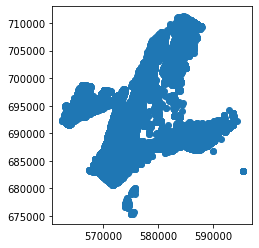

In [6]:
deedsgeo.plot()

## defining residential parcels

In [7]:
all_properties = gpd.read_file("data/newark_zoning/Zoning.shp")
res_properties = all_properties[all_properties['PROPCLASS']=='2']


In [245]:
res_properties_counts = res_properties[['OBJECTID', 'geometry']]

res_properties_counts = res_properties_counts.rename(columns = {'OBJECTID':'res_parcel_num'})

# blocks for 2010 and 2020
b10 = gpd.read_file('data/newark_blocks/tl_2020_34_tabblock10_newark_res.geojson')
b20 = gpd.read_file('data/newark_blocks/tl_2020_34_tabblock20_newark_res.geojson')

wards = gpd.read_file('data/newark_wards/Wards_2012.shp')

print("2010 blocks crs: ",b10.crs,"2020 blocks crs: ", b20.crs, "wards crs: ",wards.crs)


2010 blocks crs:  epsg:3424 2020 blocks crs:  epsg:3424 wards crs:  epsg:3424


In [246]:
# creating a string type version of the year
deedsgeo["year_"] = deedsgeo['year'].astype(str).str[:4]
# deedsgeo["year_"] = deedsgeo['year_']

In [247]:
# spatial join of deeds to two sets of block groups
deeds_b_00_10 = gpd.sjoin(b10,deedsgeo.loc[deedsgeo["year"]<=2010], how='left', op='intersects').reset_index()
deeds_b_10_20 = gpd.sjoin(b20,deedsgeo.loc[deedsgeo["year"]>2010], how='left', op='intersects').reset_index()

In [248]:
# getting counts of purchases by type for year block for each year
grouped_deeds00_10 = deeds_b_00_10.groupby(["GEOID10","year_"]).agg({'investor_all':'sum',
                                                     'owner_occup': 'sum','count_field':'count'}).unstack()

# getting counts of purchases by type for year block for each year
grouped_deeds10_20 = deeds_b_10_20 .groupby(["GEOID20","year_",]).agg({'investor_all':'sum',
                                                     'owner_occup': 'sum','count_field':'count'}).unstack()

In [249]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in grouped_deeds00_10.columns]
grouped_deeds00_10.columns = new_cols

new_cols20 = [''.join(t) for t in grouped_deeds10_20.columns]
grouped_deeds10_20.columns = new_cols20


In [250]:
# getting geometry column
b10_geometry = b10[['GEOID10','geometry']]
b20_geometry = b20[['GEOID20','geometry']]

In [251]:
# merging grouped blocks with geometry field
grouped_deeds00_10 = b10_geometry.merge(grouped_deeds00_10,
                                        how='left',
                                        left_on='GEOID10',
                                        right_on='GEOID10')
grouped_deeds10_20 = b20_geometry.merge(grouped_deeds10_20,
                                        how='left',
                                        left_on='GEOID20',
                                        right_on='GEOID20')

# converting to a geodataframe
grouped_deeds00_10 = gpd.GeoDataFrame(grouped_deeds00_10, 
                                      geometry=grouped_deeds00_10['geometry'])
grouped_deeds10_20 = gpd.GeoDataFrame(grouped_deeds10_20, 
                                      geometry=grouped_deeds10_20['geometry'])

In [252]:
# joining residential parcels from land use to blocks to have count of parcels
# deeds_b_00_10_i = deeds_b_00_10_i.drop(columns = ['index_right'])
# deeds_b_10_18_i = deeds_b_10_18_i.drop(columns = ['index_right'])
res_b_00_10 = gpd.sjoin(b10,res_properties_counts, how='left', op='intersects').reset_index() 
res_b_10_20 = gpd.sjoin(b20,res_properties_counts, how='left', op='intersects').reset_index() 

In [253]:
res_count00 = res_b_00_10.groupby(["GEOID10"]).agg({'res_parcel_num':'count'}).reset_index()
res_count10 = res_b_10_20.groupby(["GEOID20"]).agg({'res_parcel_num':'count'}).reset_index()

In [254]:
grouped_deeds00_10_i = grouped_deeds00_10.merge(res_count00,
                                                how='left',
                                                left_on='GEOID10',
                                                right_on='GEOID10')
grouped_deeds10_20_i = grouped_deeds10_20.merge(res_count10,
                                                how='left',
                                                left_on='GEOID20',
                                                right_on='GEOID20')

In [255]:
# percent of purchases by block that are investor purchases 2000
grouped_deeds00_10_i['per_inv_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_inv_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_inv_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_inv_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_inv_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_inv_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_inv_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_inv_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_inv_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_inv_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds00_10_i['per_inv_2010'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_20_i['per_inv_2011'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_20_i['per_inv_2012'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_20_i['per_inv_2013'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_20_i['per_inv_2014'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_20_i['per_inv_2015'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_20_i['per_inv_2016'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_20_i['per_inv_2017'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_20_i['per_inv_2018'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['investor_all2018']/x['res_parcel_num'], axis=1)

grouped_deeds10_20_i['per_inv_2019'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['investor_all2019']/x['res_parcel_num'], axis=1)

grouped_deeds10_20_i['per_inv_2020'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['investor_all2020']/x['res_parcel_num'], axis=1)

In [256]:
# percent of purchases by block that are investor purchases 2000
grouped_deeds00_10_i['per_occ_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_occ_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_occ_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_occ_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_occ_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_occ_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_occ_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_occ_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_occ_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_occ_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds00_10_i['per_occ_2010'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_20_i['per_occ_2011'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_20_i['per_occ_2012'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_20_i['per_occ_2013'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_20_i['per_occ_2014'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_20_i['per_occ_2015'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_20_i['per_occ_2016'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_20_i['per_occ_2017'] = grouped_deeds10_20_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_20_i['per_occ_2018'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['owner_occup2018']/x['res_parcel_num'], axis=1)

grouped_deeds10_20_i['per_occ_2019'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['owner_occup2019']/x['res_parcel_num'], axis=1)


grouped_deeds10_20_i['per_occ_2020'] = grouped_deeds10_20_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['owner_occup2020']/x['res_parcel_num'], axis=1)



In [257]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var1020 = [i for i in grouped_deeds10_20_i.columns]
var0010 = [i for i in grouped_deeds00_10_i.columns]
var1020.remove('geometry')
var0010.remove('geometry')

In [258]:
grouped_deeds10_20_i = grouped_deeds10_20_i.fillna({f:0 for f in var1020})
grouped_deeds00_10_i = grouped_deeds00_10_i.fillna({f:0 for f in var0010})

In [259]:
# saving to file
grouped_deeds10_20_i.to_file("data/PROCESSED/grouped_deeds10_20_i_blocks_res.geojson", driver = "GeoJSON")
grouped_deeds00_10_i.to_file("data/PROCESSED/grouped_deeds00_10_i_blocks_res.geojson", driver = "GeoJSON")

### 5. Assessing Global Spatial Autocorrelation

In [260]:
## can read grouped deeds in from here.....
# grouped_deeds10_20_i = gpd.read_file("data/PROCESSED/grouped_deeds10_20_i_blocks.geojson")
# grouped_deeds00_10_i = gpd.read_file("data/PROCESSED/grouped_deeds00_10_i_blocks.geojson")

In [261]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

In [262]:
# creating spatial weight for 2000-2010 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight_00_10 = DistanceBand.from_dataframe(grouped_deeds00_10_i, threshold=2640)

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 3 disconnected observations 
  Island ids: 4, 5, 330
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [263]:
# creating spatial weight for 2010-2018 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weigh
weight_10_20 = DistanceBand.from_dataframe(grouped_deeds10_20_i, threshold=2640)

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/util.py:804: UserWarning: There is one disconnected observation (no neighbors).
Island id: 226
  w = W(neighbors, weights, ids, **kwargs)
/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/distance.py:783: UserWarning: There is one disconnected observation (no neighbors).
Island id: 226
  W.__init__(self, neighbors, weights, ids, silence_warnings=self.silence_warnings)


### 5b. Global Moran (by_col)
creating a table of global morans i results

In [291]:
## 2000-2010
global_moran_00_10 = Moran.by_col(grouped_deeds00_10_i,
       ['per_inv_2000','per_inv_2001','per_inv_2002',
       'per_inv_2003','per_inv_2004','per_inv_2005',
       'per_inv_2006','per_inv_2007','per_inv_2008',
       'per_inv_2009','per_inv_2010'],w=weight_00_10, inplace=False)


In [287]:
# ## 2010-2020
global_moran_10_20 = Moran.by_col(grouped_deeds10_20_i,
       ['per_inv_2011','per_inv_2012',
       'per_inv_2013','per_inv_2014','per_inv_2015',
       'per_inv_2016','per_inv_2017','per_inv_2018',
    'per_inv_2019','per_inv_2020'],w=weight_10_20, inplace=False)

In [293]:
# formatting results into a single table with global moran's results for each year
keep0010 = ['per_inv_2000_moran', 'per_inv_2000_p_sim',
       'per_inv_2001_moran', 'per_inv_2001_p_sim', 'per_inv_2002_moran',
       'per_inv_2002_p_sim', 'per_inv_2003_moran', 'per_inv_2003_p_sim',
       'per_inv_2004_moran', 'per_inv_2004_p_sim', 'per_inv_2005_moran',
       'per_inv_2005_p_sim', 'per_inv_2006_moran', 'per_inv_2006_p_sim',
       'per_inv_2007_moran', 'per_inv_2007_p_sim', 'per_inv_2008_moran',
       'per_inv_2008_p_sim', 'per_inv_2009_moran', 'per_inv_2009_p_sim',
       'per_inv_2010_moran', 'per_inv_2010_p_sim']

keep1020 = ['per_inv_2011_moran',
       'per_inv_2011_p_sim', 'per_inv_2012_moran', 'per_inv_2012_p_sim',
       'per_inv_2013_moran', 'per_inv_2013_p_sim', 'per_inv_2014_moran',
       'per_inv_2014_p_sim', 'per_inv_2015_moran', 'per_inv_2015_p_sim',
       'per_inv_2016_moran', 'per_inv_2016_p_sim', 'per_inv_2017_moran',
       'per_inv_2017_p_sim', 'per_inv_2018_moran', 'per_inv_2018_p_sim',
           'per_inv_2019_moran', 'per_inv_2019_p_sim','per_inv_2020_moran', 'per_inv_2020_p_sim']
global_moran_00_10 = global_moran_00_10[keep0010]
global_moran_10_20 = global_moran_10_20[keep1020]
global_moran_00_10 = global_moran_00_10.loc[0]
global_moran_10_20 = global_moran_10_20.loc[0]

global_moran_10_20 = global_moran_10_20.to_frame()
global_moran_00_10 =global_moran_00_10.to_frame()

global_moran_00_20 = global_moran_00_10.append(global_moran_10_20)
global_moran_00_20 = global_moran_00_20.reset_index()

global_moran_00_20['year'] = global_moran_00_20['index'].str[8:12]
global_moran_00_20['type'] = global_moran_00_20['index'].str[-5:]

global_moran_00_20_table = global_moran_00_20.pivot(index='year',columns='type', values =0)

In [295]:
global_moran_00_20_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
type,,,,,,,,,,,,,,,,,,,,,
moran,0.036173,0.045807,0.006571,0.038895,0.010201,0.013062,0.067917,0.041814,0.019366,0.086581,0.03122,0.051334,0.023929,0.025213,0.026037,0.069704,0.067312,0.098707,0.045454,0.075695,0.021152
p_sim,0.001000,0.001000,0.004000,0.001000,0.002000,0.006000,0.001000,0.001000,0.001000,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.002000,0.001000,0.001000


### 6. Calculating Local Morans i for blocks and percent investor purchases

In [267]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

In [268]:
moran2000_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2000',weight_00_10)
moran2001_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2001',weight_00_10)
moran2002_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2002',weight_00_10)
moran2003_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2003',weight_00_10)
moran2004_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2004',weight_00_10)
moran2005_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2005',weight_00_10)
moran2006_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2006',weight_00_10)
moran2007_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2007',weight_00_10)
moran2008_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2008',weight_00_10)
moran2009_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2009',weight_00_10)


moran2010_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2010',weight_00_10)
moran2011_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2011',weight_10_20)
moran2012_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2012',weight_10_20)
moran2013_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2013',weight_10_20)
moran2014_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2014',weight_10_20)
moran2015_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2015',weight_10_20)
moran2016_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2016',weight_10_20)
moran2017_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2017',weight_10_20)
moran2018_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2018',weight_10_20)
moran2019_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2019',weight_10_20)
moran2020_loc = fast_local_morans(grouped_deeds10_20_i,'per_inv_2020',weight_10_20)




per_inv_2000
per_inv_2001
per_inv_2002
per_inv_2003
per_inv_2004
per_inv_2005
per_inv_2006
per_inv_2007
per_inv_2008
per_inv_2009
per_inv_2010
per_inv_2011
('WARNING: ', 226, ' is an island (no neighbors)')
per_inv_2012
per_inv_2013
per_inv_2014
per_inv_2015
per_inv_2016
per_inv_2017
per_inv_2018
per_inv_2019
per_inv_2020


### 6b. Calculating Local Morans i for blocks and percent owner purchases

In [269]:
moran2000_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2000',weight_00_10)
moran2001_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2001',weight_00_10)
moran2002_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2002',weight_00_10)
moran2003_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2003',weight_00_10)
moran2004_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2004',weight_00_10)
moran2005_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2005',weight_00_10)
moran2006_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2006',weight_00_10)
moran2007_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2007',weight_00_10)
moran2008_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2008',weight_00_10)
moran2009_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2009',weight_00_10)
moran2010_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2010',weight_00_10)

moran2011_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2011',weight_10_20)
moran2012_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2012',weight_10_20)
moran2013_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2013',weight_10_20)
moran2014_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2014',weight_10_20)
moran2015_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2015',weight_10_20)
moran2016_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2016',weight_10_20)
moran2017_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2017',weight_10_20)
moran2018_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2018',weight_10_20)
moran2019_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2019',weight_10_20)
moran2020_loc_occ= fast_local_morans(grouped_deeds10_20_i,'per_occ_2020',weight_10_20)



per_occ_2000
per_occ_2001
per_occ_2002
per_occ_2003
per_occ_2004
per_occ_2005
per_occ_2006
per_occ_2007
per_occ_2008
per_occ_2009
per_occ_2010
per_occ_2011
per_occ_2012
per_occ_2013
per_occ_2014
per_occ_2015
per_occ_2016
per_occ_2017
per_occ_2018
per_occ_2019
per_occ_2020


## 8. finding hh blocks for local morans i 

In [270]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    

In [271]:
# Calculating for investors & owners 2000-2010
morans0010=[moran2000_loc,moran2000_loc_occ,moran2001_loc,moran2001_loc_occ,moran2002_loc,moran2002_loc_occ,
            moran2003_loc,moran2003_loc_occ,moran2004_loc,moran2004_loc_occ,moran2005_loc,moran2005_loc_occ,
            moran2006_loc,moran2006_loc_occ,moran2007_loc,moran2007_loc_occ,moran2008_loc,moran2008_loc_occ,
            moran2009_loc,moran2009_loc_occ,moran2010_loc,moran2010_loc_occ]
morans0010_names=['moran2000_loc','moran2000_loc_occ','moran2001_loc','moran2001_loc_occ','moran2002_loc',
                  'moran2002_loc_occ','moran2003_loc','moran2003_loc_occ','moran2004_loc','moran2004_loc_occ',
                  'moran2005_loc','moran2005_loc_occ','moran2006_loc','moran2006_loc_occ','moran2007_loc',
                  'moran2007_loc_occ','moran2008_loc','moran2008_loc_occ','moran2009_loc','moran2009_loc_occ',
                 'moran2010_loc','moran2010_loc_occ']
col_names=['inv_hh00','occ_hh00','inv_hh01','occ_hh01','inv_hh02','occ_hh02','inv_hh03','occ_hh03',
           'inv_hh04','occ_hh04','inv_hh05','occ_hh05','inv_hh06','occ_hh06','inv_hh07','occ_hh07',
           'inv_hh08','occ_hh08','inv_hh09','occ_hh09','inv_hh10','occ_hh10']
morans_hh_0010 = hh_columns(grouped_deeds00_10_i,morans0010,morans0010_names,col_names)

calculated hh clusters for given list of local morans i


In [272]:
# Calculating for investors & owners 2010-2018
morans1020=[moran2011_loc,moran2011_loc_occ,moran2012_loc,moran2012_loc_occ,
            moran2013_loc,moran2013_loc_occ,moran2014_loc,moran2014_loc_occ,moran2015_loc,moran2015_loc_occ,
            moran2016_loc,moran2016_loc_occ,moran2017_loc,moran2017_loc_occ,moran2018_loc,moran2018_loc_occ,
           moran2019_loc,moran2019_loc_occ,moran2020_loc,moran2020_loc_occ]
morans1020_names=['moran2011_loc','moran2011_loc_occ','moran2012_loc',
                  'moran2012_loc_occ','moran2013_loc','moran2013_loc_occ','moran2014_loc','moran2014_loc_occ',
                  'moran2015_loc','moran2015_loc_occ','moran2016_loc','moran2016_loc_occ','moran2017_loc',
                  'moran2017_loc_occ','moran2018_loc','moran2018_loc_occ','moran2019_loc','moran2019_loc_occ',
                 'moran2020_loc','moran2020_loc_occ']
col_names1020=['inv_hh11','occ_hh11','inv_hh12','occ_hh12','inv_hh13','occ_hh13',
               'inv_hh14','occ_hh14','inv_hh15','occ_hh15','inv_hh16','occ_hh16','inv_hh17','occ_hh17',
               'inv_hh18','occ_hh18','inv_hh19','occ_hh19','inv_hh20','occ_hh20']
morans_hh_1020 = hh_columns(grouped_deeds10_20_i,morans1020,morans1020_names,col_names1020)

calculated hh clusters for given list of local morans i


In [273]:
# calculating column showing overlap 2000-2010
morans_hh_0010['overlap00'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh00==True) 
                                                   and (x.occ_hh00==True) else 0,axis=1)
morans_hh_0010['overlap01'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh01==True) 
                                                   and (x.occ_hh01==True) else 0,axis=1)
morans_hh_0010['overlap02'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh02==True) 
                                                   and (x.occ_hh02==True) else 0,axis=1)
morans_hh_0010['overlap03'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh03==True) 
                                                   and (x.occ_hh03==True) else 0,axis=1)
morans_hh_0010['overlap04'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh04==True) 
                                                   and (x.occ_hh04==True) else 0,axis=1)
morans_hh_0010['overlap05'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh05==True) 
                                                   and (x.occ_hh05==True) else 0,axis=1)
morans_hh_0010['overlap06'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh06==True) 
                                                   and (x.occ_hh06==True) else 0,axis=1)
morans_hh_0010['overlap07'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh07==True) 
                                                   and (x.occ_hh07==True) else 0,axis=1)
morans_hh_0010['overlap08'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh08==True) 
                                                   and (x.occ_hh08==True) else 0,axis=1)
morans_hh_0010['overlap09'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh09==True) 
                                                   and (x.occ_hh09==True) else 0,axis=1)
morans_hh_0010['overlap10'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh10==True) 
                                                   and (x.occ_hh10==True) else 0,axis=1)

In [274]:
# calculating column showing overlap 2011-2020

morans_hh_1020['overlap11'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh11==True) 
                                                   and (x.occ_hh11==True) else 0,axis=1)
morans_hh_1020['overlap12'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh12==True) 
                                                   and (x.occ_hh12==True) else 0,axis=1)
morans_hh_1020['overlap13'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh13==True) 
                                                   and (x.occ_hh13==True) else 0,axis=1)
morans_hh_1020['overlap14'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh14==True) 
                                                   and (x.occ_hh14==True) else 0,axis=1)
morans_hh_1020['overlap15'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh15==True) 
                                                   and (x.occ_hh15==True) else 0,axis=1)
morans_hh_1020['overlap16'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh16==True) 
                                                   and (x.occ_hh16==True) else 0,axis=1)
morans_hh_1020['overlap17'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh17==True) 
                                                   and (x.occ_hh17==True) else 0,axis=1)
morans_hh_1020['overlap18'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh18==True) 
                                                   and (x.occ_hh18==True) else 0,axis=1)
morans_hh_1020['overlap19'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh19==True) 
                                                   and (x.occ_hh19==True) else 0,axis=1)
morans_hh_1020['overlap20'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh20==True) 
                                                   and (x.occ_hh20==True) else 0,axis=1)


In [330]:
overlap_cols =  ['overlap11','overlap12','overlap13','overlap14','overlap15','overlap16','overlap17','overlap18','overlap19','overlap20']


def check_val(list_columns):
    for i,val in enumerate(list_columns):
        print("i: ", i);
        print("val: ", val)
        return val
        

In [342]:
# 2011-2020
# finding blocks cumulative that were in one or another cluster
morans_hh_1020['overlap_all'] = morans_hh_1020.apply(lambda x: 1 if (x.overlap11==True) or
                                                     (x.overlap12==True) or
                                                     (x.overlap13==True) or
                                                     (x.overlap14==True) or
                                                     (x.overlap15==True) or
                                                     (x.overlap16==True) or
                                                     (x.overlap17==True) or
                                                     (x.overlap18==True) or
                                                     (x.overlap19==True) or
                                                     (x.overlap20==True) else 0,axis=1)


morans_hh_1020['own_all'] = morans_hh_1020.apply(lambda x: 1 if (x.occ_hh11==True) or
                                                     (x.occ_hh12==True) or
                                                     (x.occ_hh13==True) or
                                                     (x.occ_hh14==True) or
                                                     (x.occ_hh15==True) or
                                                     (x.occ_hh16==True) or
                                                     (x.occ_hh17==True) or
                                                     (x.occ_hh18==True) or
                                                     (x.occ_hh19==True) or
                                                     (x.occ_hh20==True) else 0,axis=1)

morans_hh_1020['inv_all'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh11==True) or
                                                     (x.inv_hh12==True) or
                                                     (x.inv_hh13==True) or
                                                     (x.inv_hh14==True) or
                                                     (x.inv_hh15==True) or
                                                     (x.inv_hh16==True) or
                                                     (x.inv_hh17==True) or
                                                     (x.inv_hh18==True) or
                                                     (x.inv_hh19==True) or
                                                     (x.inv_hh20==True) else 0,axis=1)


In [345]:
# 2000-2010
# finding blocks cumulative that were in one or another cluster
morans_hh_0010['overlap_all'] = morans_hh_0010.apply(lambda x: 1 if (x.overlap01==True) or
                                                     (x.overlap02==True) or
                                                     (x.overlap03==True) or
                                                     (x.overlap04==True) or
                                                     (x.overlap05==True) or
                                                     (x.overlap06==True) or
                                                     (x.overlap07==True) or
                                                     (x.overlap08==True) or
                                                     (x.overlap09==True) or
                                                     (x.overlap10==True) else 0,axis=1)


morans_hh_0010['own_all'] = morans_hh_0010.apply(lambda x: 1 if (x.occ_hh01==True) or
                                                     (x.occ_hh02==True) or
                                                     (x.occ_hh03==True) or
                                                     (x.occ_hh04==True) or
                                                     (x.occ_hh05==True) or
                                                     (x.occ_hh06==True) or
                                                     (x.occ_hh07==True) or
                                                     (x.occ_hh08==True) or
                                                     (x.occ_hh09==True) or
                                                     (x.occ_hh10==True) else 0,axis=1)

morans_hh_0010['inv_all'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh01==True) or
                                                     (x.inv_hh02==True) or
                                                     (x.inv_hh03==True) or
                                                     (x.inv_hh04==True) or
                                                     (x.inv_hh05==True) or
                                                     (x.inv_hh06==True) or
                                                     (x.inv_hh07==True) or
                                                     (x.inv_hh08==True) or
                                                     (x.inv_hh09==True) or
                                                     (x.inv_hh10==True) else 0,axis=1)


In [343]:
print("own: ",morans_hh_1020['own_all'].sum())
print("invest: ",morans_hh_1020['inv_all'].sum())
print("overlap: ",morans_hh_1020['overlap_all'].sum())

own:  566
invest:  469
overlap:  258


In [ ]:
morans_hh_1020.apply(lambda x: 1 if (x.list_columns[val]==True) else 0,axis=1)

## plotting context features

In [275]:
non_residential = all_properties[(all_properties['ZONING']=='I-H')|
                                 (all_properties['ZONING']=='I-L')|
                                 (all_properties['ZONING']=='I-M')|
                                 (all_properties['ZONING']=='PARK')|
                                 (all_properties['ZONING']=='PORT')|
                                 (all_properties['ZONING']=='WF')|
                                 (all_properties['ZONING']=='EWR')|
                                 (all_properties['ZONING']=='I-H')|
                                 (all_properties['ZONING'].isna())].copy()

In [276]:
parks = all_properties[(all_properties['ZONING']=='PARK')].copy()

In [277]:
roads = gpd.read_file("data/newark_context_features/newark_road-centerline.geojson")
water = gpd.read_file("data/newark_context_features/water_newark_.geojson")
buildings = gpd.read_file("data/newark_context_features/newark_building_footprints.geojson")

In [278]:
roads_formap = roads[roads['SYMBOLTYPE']<700].copy()

In [349]:
boundary = gpd.read_file("data/newark_context_features/newark_city_limits.geojson")

## Plotting overlaps

In [280]:
inv_hh = ['#FFFFFF00','#FF7C00FF']
inv_hh_map = colors.ListedColormap(inv_hh)
occ_hh = ['#FFFFFF00','#AA29BEFF']
# occ_hh = [(255,255,255,0),(0,0,0,1)]

occ_hh_map = colors.ListedColormap(occ_hh)

over = ['#FFFFFF00','#00FFFFFF']
over_hh_map = colors.ListedColormap(over)

In [299]:
wards.crs

<Projected CRS: EPSG:3424>
Name: NAD83 / New Jersey (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New Jersey - counties of Atlantic; Bergen; Burlington; Camden; Cape May; Cumberland; Essex; Gloucester; Hudson; Hunterdon; Mercer; Middlesex; Monmouth; Morris; Ocean; Passaic; Salem; Somerset; Sussex; Union; Warren.
- bounds: (-75.6, 38.87, -73.88, 41.36)
Coordinate Operation:
- name: SPCS83 New Jersey zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

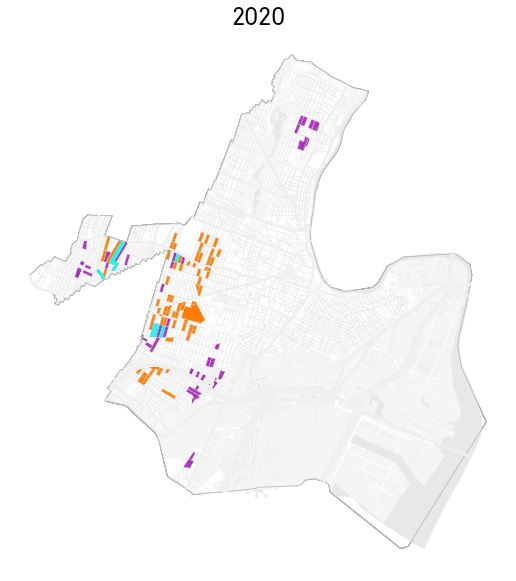

In [363]:
# 2011 - 2020
col_list = ["overlap11","overlap12","overlap13","overlap14","overlap15","overlap16","overlap17","overlap18","overlap19","overlap20"]
ownhh = ["occ_hh11","occ_hh12","occ_hh13","occ_hh14","occ_hh15","occ_hh16","occ_hh17","occ_hh18","occ_hh19","occ_hh20"]
invhh = ["inv_hh11","inv_hh12","inv_hh13","inv_hh14","inv_hh15","inv_hh16","inv_hh17","inv_hh18","inv_hh19","inv_hh20"]
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
# names = ["res_overlap11","res_overlap12","res_overlap13","res_overlap14","res_overlap15","res_overlap16","res_overlap17","res_overlap18","res_overlap19","res_overlap20"]

fig, ax = plt.subplots(figsize=(10,10))

for i,val in enumerate(col_list):
    wards.plot(color='#fff',edgecolor=None,ax=ax)
    morans_hh_1020.plot(column=ownhh[i],cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_1020.plot(column=invhh[i],cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_1020.plot(column=val,cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)


    ax.set_title(years[i],fontname="Akkurat Pro",fontsize=24)
    ax.set_axis_off()
    plt.savefig('exports/'+col_list[i]+'.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


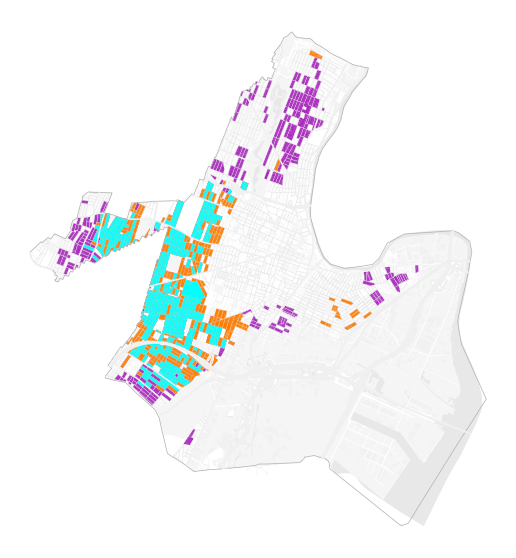

In [351]:
# 2011 - 2020 all overlaps

fig, ax = plt.subplots(figsize=(10,10))

wards.plot(color='#fff',edgecolor=None,ax=ax)
morans_hh_1020.plot(column="own_all",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_1020.plot(column="inv_all",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_1020.plot(column="overlap_all",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')    
buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
roads_formap.plot(ax=ax, color="#F0F0F0",);
boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_title(years[i])
ax.set_axis_off()
plt.savefig('exports/2011-2020overlaps.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


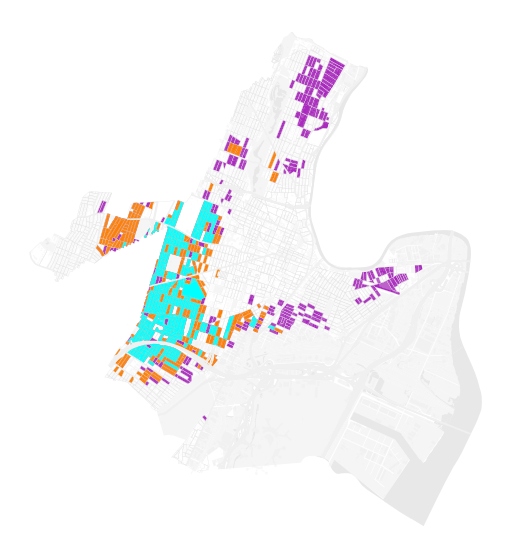

In [364]:
# 2000 - 2010 all overlaps

fig, ax = plt.subplots(figsize=(10,10))

wards.plot(color='#fff',edgecolor=None,ax=ax)
morans_hh_0010.plot(column="own_all",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_0010.plot(column="inv_all",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_0010.plot(column="overlap_all",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')    
buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
roads_formap.plot(ax=ax, color="#F0F0F0",);
# ax.set_title("2018",fontname="Akkurat Pro",fontsize=24)
# ax.set_title(years[i])
ax.set_axis_off()
plt.savefig('exports/2000-10alloverlap.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


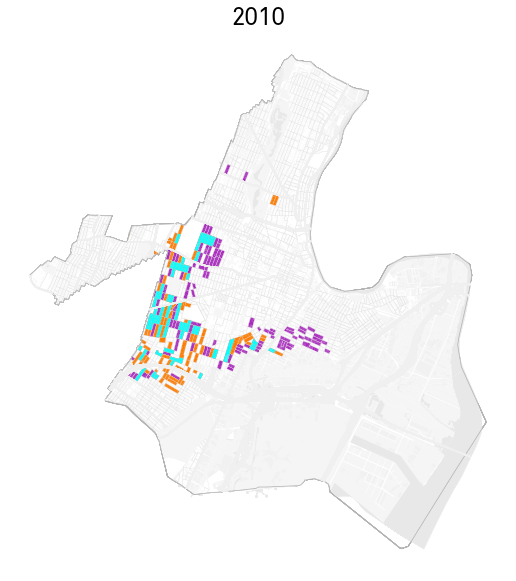

In [365]:
# 2000 - 2010


moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc,moran2010_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png','inv2010.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']


col_list = ["overlap00","overlap01","overlap02","overlap03","overlap04","overlap05","overlap06","overlap07","overlap08","overlap09","overlap10"]
ownhh = ["occ_hh00","occ_hh01","occ_hh02","occ_hh03","occ_hh04","occ_hh05","occ_hh06","occ_hh07","occ_hh08","occ_hh09","occ_hh10"]
invhh = ["inv_hh00","inv_hh01","inv_hh02","inv_hh03","inv_hh04","inv_hh05","inv_hh06","inv_hh07","inv_hh08","inv_hh09","inv_hh10"]
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']

# names = ["res_overlap11","res_overlap12","res_overlap13","res_overlap14","res_overlap15","res_overlap16","res_overlap17","res_overlap18","res_overlap19","res_overlap20"]

fig, ax = plt.subplots(figsize=(10,10))

for i,val in enumerate(col_list):
    wards.plot(color='#fff',edgecolor=None,ax=ax)
    morans_hh_0010.plot(column=ownhh[i],cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_0010.plot(column=invhh[i],cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_0010.plot(column=val,cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)


    ax.set_title(years[i],fontname="Akkurat Pro",fontsize=24)
    ax.set_axis_off()
    plt.savefig('exports/'+col_list[i]+'.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


## 9. custom lisa cluster function to change colors

Defines colors as orange and blue cmap

In [283]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> import matplotlib.colors as colors
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#e6e6e6', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [284]:
import matplotlib.colors as colors

## color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']

#ALT muted oragne/blue
# colors_investor = ['#E6A554','#F9E0BB','#A5BDFF','#173878','white']

# lighter
# colors_owner =['#4E2C83','#8885bc','#91b597','#def0a7','white']


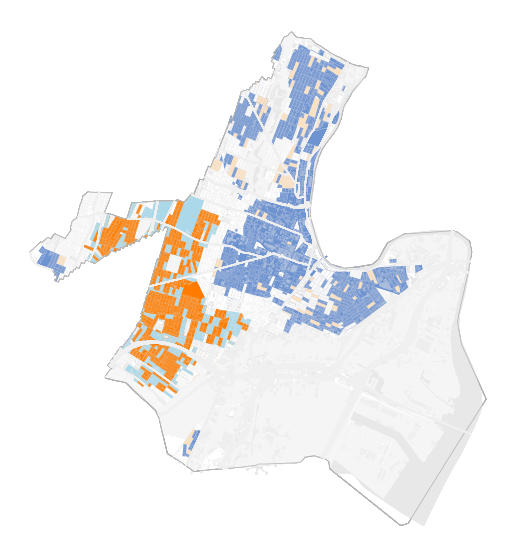

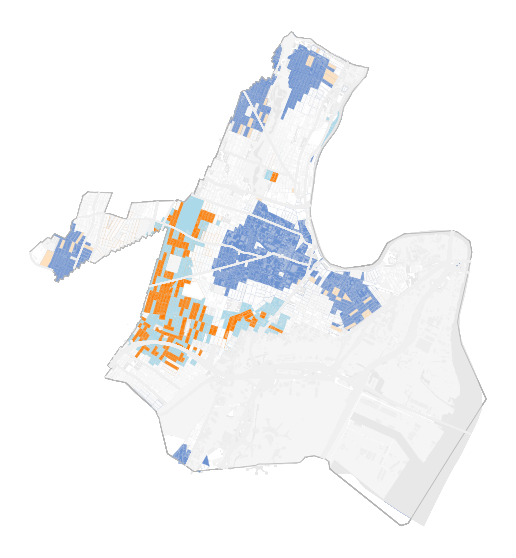

In [367]:
## method to batch export individual plots INVESTOR 

moran_list = [moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc,moran2019_loc]
files_list = ['inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png','inv2019.png']
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019']
# moran_list = [ moran2018_loc]
# files_list = ['inv2018.png']
# years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_20_i, p=0.05,ax=ax,legend=False)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e8',alpha=0.5)

#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

    
#     planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
#     districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
#                                           ha='center',fontname="Helvetica", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')

    
moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc,moran2010_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png','inv2010.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5')

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e8',alpha=0.5)

#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

#     planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
#     districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
#                                           ha='center',fontname="Helvetica", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')


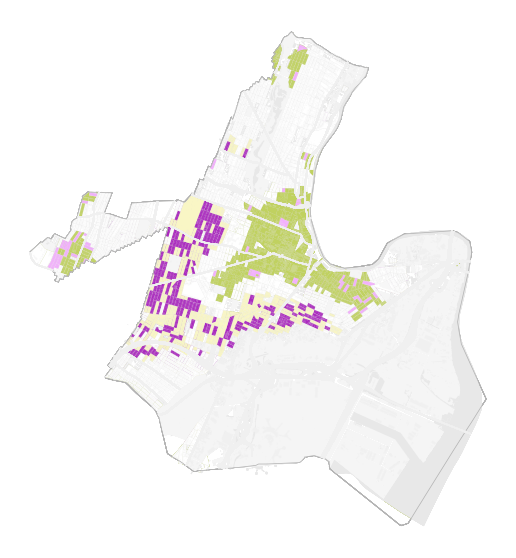

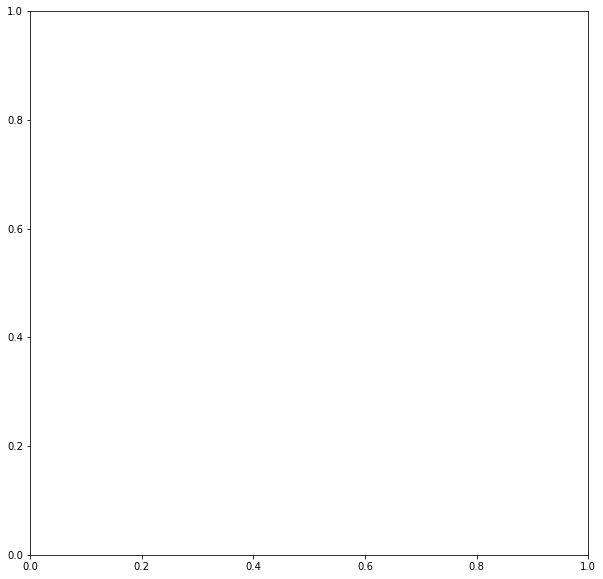

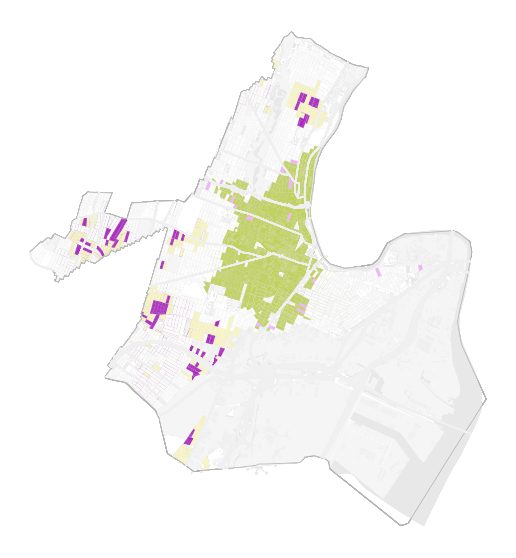

In [366]:
## method to batch export individual plots OWNER 

moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ,moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ, moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,moran2009_loc_occ,moran2010_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png','occ2010.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5');

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850')

# #     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

#     planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
#     districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
#                                           ha='center',fontname="Helvetica", fontsize=11,color='#5A5A5A'),axis=1);    
#     ax.set_title(years[i])
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')
    
    
## method to batch export individual plots OWNER 

moran_list = [moran2011_loc_occ, moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ,moran2019_loc_occ,moran2020_loc_occ]
files_list = ['occ2011.png','occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png','occ2019.png','occ2020.png']
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']

fig, ax = plt.subplots(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_20_i, p=0.05,ax=ax,legend=False)
    non_residential.plot(ax=ax,edgecolor='none',color='#f5f5f5');

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    buildings.plot(ax=ax,edgecolor='none',color='#e8e8e850')
    
# #     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

#     planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
#     districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
#                                           ha='center',fontname="Helvetica", fontsize=11,color='#5A5A5A'),axis=1);    
#     ax.set_title(years[i])
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')
